In [1]:
# Customer Reviews Analysis
# This notebook focuses on analyzing customer review scores

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
order_train = pd.read_csv('../data/order_train.csv')
order_item = pd.read_csv('../data/olist_order_items_dataset.csv')
product = pd.read_csv('../data/olist_products_dataset.csv')

In [6]:
# Merge the datasets
merged_data = order_train.merge(order_item, on='order_id', how='inner')
merged_data = merged_data.merge(product, on='product_id', how='left')
reviews_agg = reviews.groupby('order_id').agg({
    'review_score': ['mean', 'min', 'max', 'count'],
    'review_comment_title': lambda x: ' '.join(x.dropna().astype(str)),
    'review_comment_message': lambda x: ' '.join(x.dropna().astype(str)),
    'review_creation_date': 'max'
}).reset_index()


reviews_agg.columns = ['order_id', 'review_score_mean', 'review_score_min', 
                       'review_score_max', 'review_count', 'review_title_combined',
                       'review_message_combined', 'review_date']

merged_data = merged_data.merge(reviews_agg, on='order_id', how='left')

In [7]:
# Filter data where reviews exist
data_with_reviews = merged_data[merged_data['review_score_mean'].notna()].copy()
data_with_reviews_unique = data_with_reviews[['order_id', 'review_score_mean', 'isLate']].drop_duplicates()

review_by_delivery = data_with_reviews_unique.groupby('isLate')['review_score_mean'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

negative_reviews = data_with_reviews_unique.groupby('isLate').apply(
    lambda x: ((x['review_score_mean'] <= 3).sum() / len(x) * 100)
).round(2)

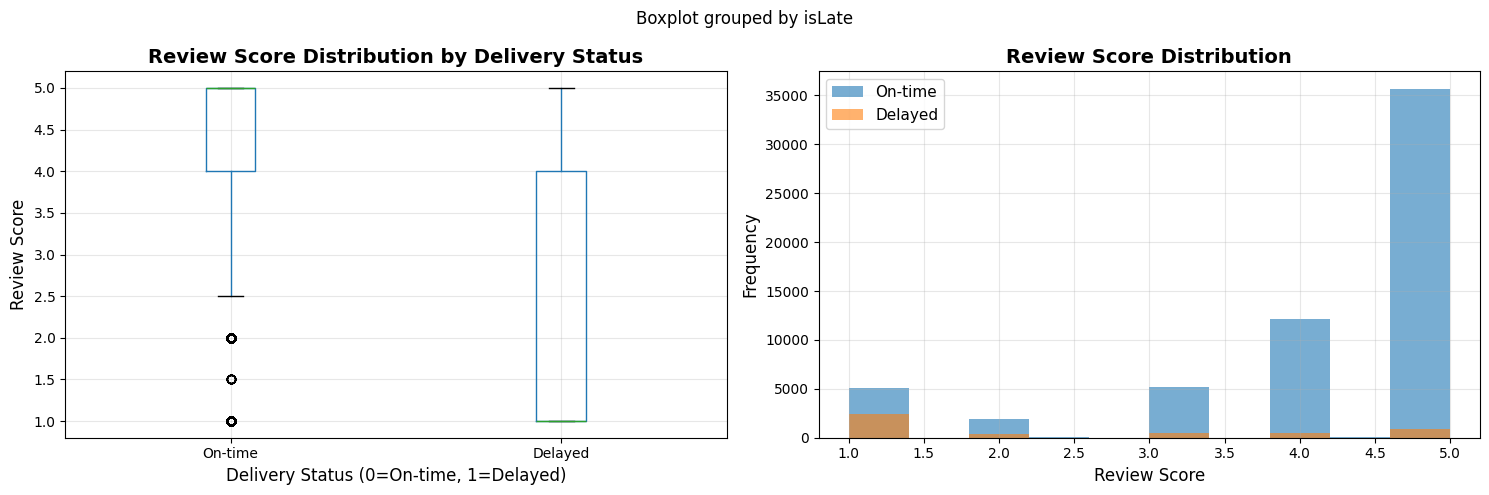

In [8]:
# Visualize review score distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
data_with_reviews.boxplot(column='review_score_mean', by='isLate', ax=axes[0])
axes[0].set_title('Review Score Distribution by Delivery Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Delivery Status (0=On-time, 1=Delayed)', fontsize=12)
axes[0].set_ylabel('Review Score', fontsize=12)
axes[0].set_xticklabels(['On-time', 'Delayed'])
axes[0].grid(True, alpha=0.3)

# Histogram
for is_late in [0, 1]:
    label = 'On-time' if is_late == 0 else 'Delayed'
    data_with_reviews[data_with_reviews['isLate'] == is_late]['review_score_mean'].hist(
        alpha=0.6, label=label, bins=10, ax=axes[1]
    )
axes[1].set_title('Review Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Review Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


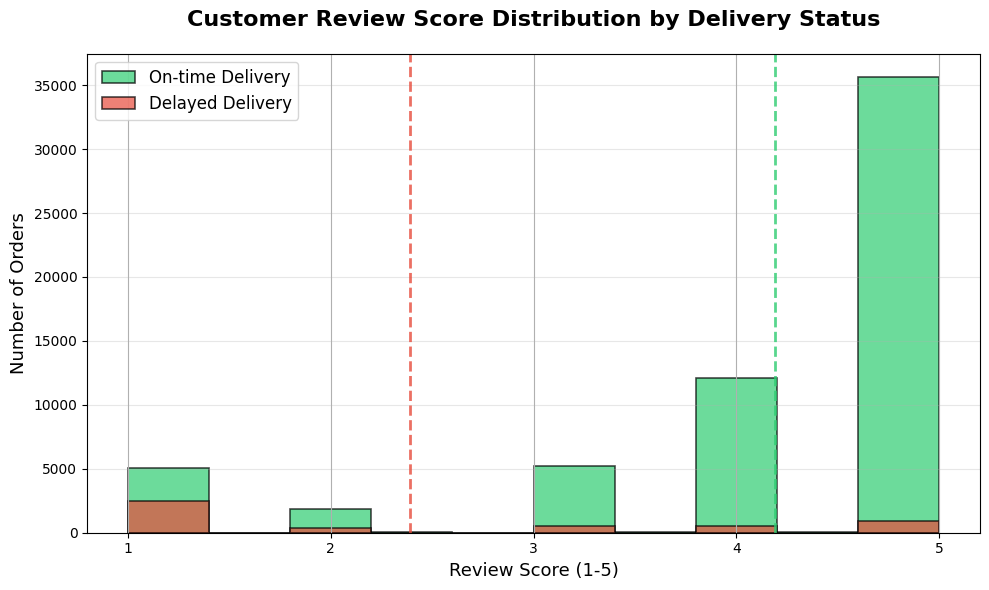

In [9]:
# Additional visualization: Review score distribution by delivery status
fig, ax = plt.subplots(figsize=(10, 6))

# Create a more detailed histogram with better styling
for is_late in [0, 1]:
    label = 'On-time Delivery' if is_late == 0 else 'Delayed Delivery'
    color = '#2ecc71' if is_late == 0 else '#e74c3c'
    data_with_reviews[data_with_reviews['isLate'] == is_late]['review_score_mean'].hist(
        alpha=0.7, label=label, bins=10, ax=ax, color=color, edgecolor='black', linewidth=1.2
    )

ax.set_title('Customer Review Score Distribution by Delivery Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Review Score (1-5)', fontsize=13)
ax.set_ylabel('Number of Orders', fontsize=13)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(1, 6))
ax.set_xticklabels(range(1, 6))

# Add mean lines
mean_on_time = data_with_reviews[data_with_reviews['isLate'] == 0]['review_score_mean'].mean()
mean_delayed = data_with_reviews[data_with_reviews['isLate'] == 1]['review_score_mean'].mean()
ax.axvline(mean_on_time, color='#2ecc71', linestyle='--', linewidth=2, alpha=0.8, label=f'On-time Mean: {mean_on_time:.2f}')
ax.axvline(mean_delayed, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8, label=f'Delayed Mean: {mean_delayed:.2f}')

plt.tight_layout()
plt.show()
